# Discrete Morse Theory

Mazeworld with Discrete Morse Theory (Chapters 1-5 of Scoville).

Build a maze with nontrivial homology. Use the optimal $Q$ and $V$ functions to define a Morse function on the maze (as a graph).

Learn the basics of Discrete Morse Theory through this example!

In [1]:
import sys

sys.path.append("../src")

from environments import MazeEnv
from policies import BaseAgent, QLearningAgent
from dmt import environment_to_graph, classify_simplices, visualize_graph

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

from tqdm import tqdm
from copy import deepcopy

In [2]:
# Get optimal value function through value iteration
env = MazeEnv()
agent = BaseAgent(env, gamma=0.999)
agent.value_iteration(threshold=1e-8, max_iterations=100000)
optimal_value_function = agent.value_function

In [3]:
# Get optimal Q function through bellman equations
env = MazeEnv()
agent = QLearningAgent(env, gamma=0.999, alpha=0.01)
agent.compute_optimal_q_function(threshold=1e-8, max_iterations=100000)
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [4]:
# check if max_a q_{opt}(s, a) == v_{opt{(s)
np.allclose(np.max(optimal_q_function, axis=-1), optimal_value_function, rtol=1e-5, atol=1e-5)

True

# Env to graph
Convert a gymnasium environment to a graph. 

We connect states $s$ and $s'$ with an edge if an action at $s$ can take us to $s'$. For now we assume the graph is undirected. So we make no distinction between edge $s\rightarrow s'$ and $s' \rightarrow s$.

We make a few assumptions about this conversion. First we assign a real-valued function on the verticies as determined by the value function. 

For the edge $(s, s')$ we consider the two values $q(s, a)$ and $q(s', a')$ where $a$ and $a'$ are the actions that take us from $s$ to $s'$ and $s'$ to $s$ respectively. We then assign the edge a value of the max of the two.

In general, the optimal $q$ function seems to always satisfy the requirements of a morse function. 

During learning of an approximate $q$ function there are very often cycles, especially in under-explored regions of the maze (basically the agent flips back and forth between two nodes).

The current approach is just a starting point. Ideally we want to incorporate the entire structure of the MDP including the probability simplex over actions at each state.

In [5]:
G = environment_to_graph(env, optimal_q_function)

In [6]:
list(G.nodes(data=True))[:5]

[(0, {'node_value': -25.676680612188346}),
 (12, {'node_value': -24.70138200415597}),
 (1, {'node_value': -26.651002931576155}),
 (2, {'node_value': -27.62434992864458}),
 (3, {'node_value': -26.651266059877173})]

In [7]:
list(G.edges(data=True))[:5]

[(0, 12, {'edge_value': -25.676680612188346}),
 (0, 1, {'edge_value': -26.651002931576155}),
 (12, 14, {'edge_value': -24.70138200415597}),
 (1, 2, {'edge_value': -27.62434992864458}),
 (2, 3, {'edge_value': -27.624612783873744})]

# Basic Morse theory

Compute all critical/regular nodes/edges.



In [8]:
# Run the classification function
(
    critical_nodes,
    regular_nodes,
    critical_edges,
    regular_edges,
) = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_edges is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")


Discrete Morse function found
Critical Nodes: [(67, {'node_value': 0})]
Regular Nodes: [(0, {'node_value': -25.676680612188346}), (12, {'node_value': -24.70138200415597}), (1, {'node_value': -26.651002931576155}), (2, {'node_value': -27.62434992864458}), (3, {'node_value': -26.651266059877173}), (4, {'node_value': -25.676946015836563}), (5, {'node_value': -24.701651677457573}), (6, {'node_value': -23.725382069470594}), (7, {'node_value': -22.748136215629778}), (8, {'node_value': -21.769913138712038}), (9, {'node_value': -20.79071186051611}), (10, {'node_value': -19.810531401861518}), (11, {'node_value': -18.82937078258766}), (13, {'node_value': -17.847229021552764}), (14, {'node_value': -23.72511913325269}), (15, {'node_value': -16.86410613763395}), (16, {'node_value': -22.7478810242404}), (17, {'node_value': -15.880001148726231}), (18, {'node_value': -21.769666700904775}), (26, {'node_value': -14.894913071741524}), (27, {'node_value': -20.790475186054298}), (19, {'node_value': -13.908

# Visualizations

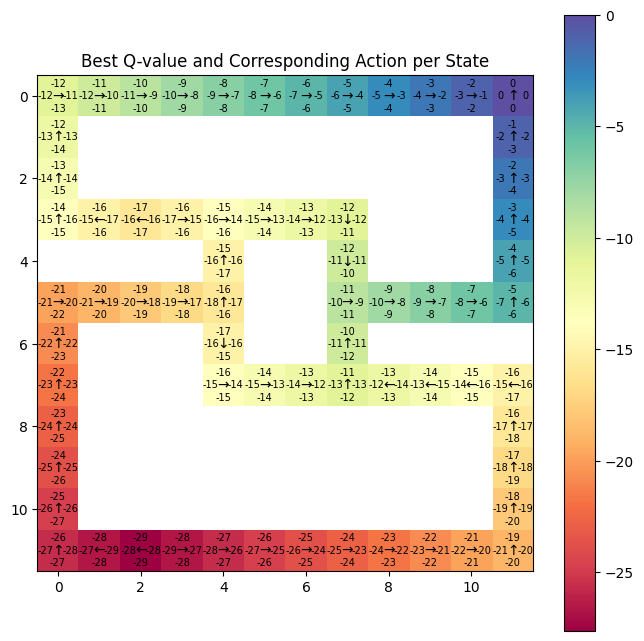

In [9]:
agent.plot_best_action_q_values()

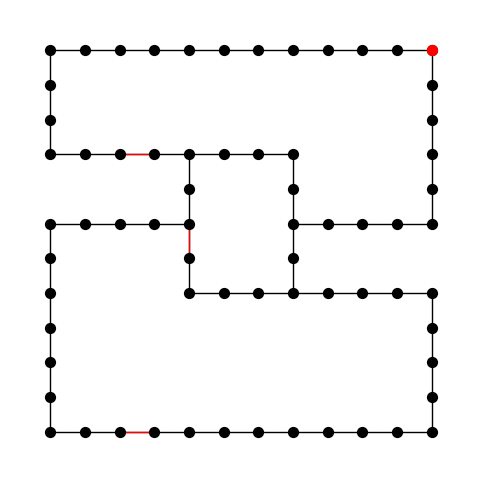

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [10]:
visualize_graph(G, env, critical_nodes, critical_edges)

# Induced Vector Field of $f$

In [11]:
from dmt import get_induced_gradient_vector_field, visualize_induced_vector_field

V = get_induced_gradient_vector_field(G)

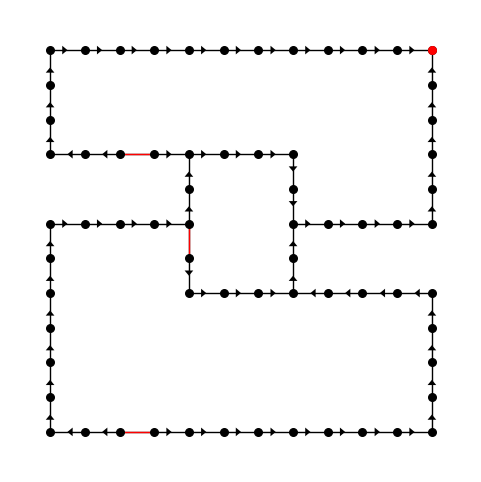

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [12]:
visualize_induced_vector_field(G, env, critical_nodes, critical_edges, V)

Optimal policy is given by the gradient paths. The critical node is the goal (terminal) state.

The critical edges are the points where you can move in either direction to get to the goal with the same total reward. The critical edges are not necessarily "decision points" in navigation.

# Homology

Betti numbers are related number of critical nodes/edges via Morse inequalities. So start by computing simplicial homology of the graph. Assume $\mathbb{R}$ coefficients.

In [13]:
from dmt import boundary_operator_r, betti_numbers

<Axes: >

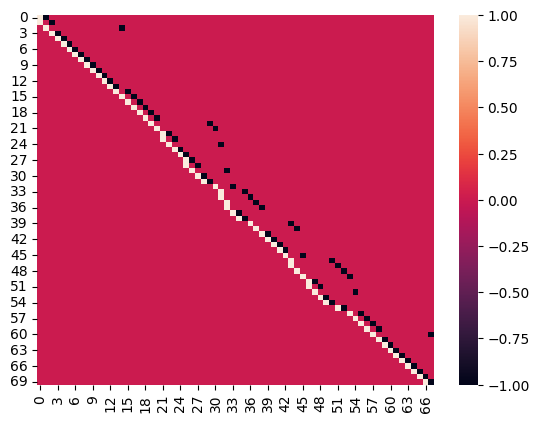

In [14]:
D = boundary_operator_r(G)
sns.heatmap(D)

In [15]:
def betti_numbers(G):
    D = boundary_operator_r(G)
    rank = np.linalg.matrix_rank(D)
    b_0 = D.shape[1] - rank
    b_1 = D.shape[0] - rank
    return b_0, b_1

In [16]:
b0, b1 = betti_numbers(G)

Theorem 2.xx tells us that the Euler characteristic $\chi = m_0 - m_1$. Let's confirm.

In [17]:
m0 = len(critical_nodes)
m1 = len(critical_edges)
chi = m0 - m1
print(chi)

-2


In [18]:
def euler_characteristic(G):
    V = G.number_of_nodes()
    E = G.number_of_edges()
    return V - E

In [19]:
euler_characteristic(G)

-2

# Homological sequences

For each critical value, compute the Betti numbers of the subcomplex of the graph.

Assumes the graph case for now.

In [20]:
def subcomplex(G, c):
    # Get the nodes whose Morse function value is less than or equal to c
    nodes = [node[0] for node in G.nodes(data=True) if -node[1]["node_value"] <= c]
    # Get the edges whose Morse function value is less than or equal to c
    edges = [edge[:2] for edge in G.edges(data=True) if -edge[2]["edge_value"] <= c]
    # Return the subgraph of G induced by these nodes and edges
    return G.edge_subgraph(edges).subgraph(nodes)

In [21]:
critical_values = [-v[-1]['node_value'] for v in critical_nodes] + [-e[-1]['edge_value'] for e in critical_edges]
critical_values = sorted(set(critical_values))

In [22]:
for c in critical_values:
    try:
        print(
            f"{betti_numbers(subcomplex(G, c))},\t {c:.02f})")
    except:
        pass

(1, 1),	 15.88)
(1, 2),	 15.88)
(1, 3),	 27.62)


# Morse Complex

A policy is a vector field on a graph. A Morse complex is a simplicial complex where each simplex is a valid vector field (a policy). We can move in the space of policies by moving along the Morse complex.

### Quantities related to the Morse complex

In [23]:
V = get_induced_gradient_vector_field(G)

In [24]:
# Rip out critical edges from G...

In [25]:
# Run the classification function
(
    critical_nodes,
    regular_nodes,
    critical_edges,
    regular_edges,
) = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_edges is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")

Discrete Morse function found
Critical Nodes: [(67, {'node_value': 0})]
Regular Nodes: [(0, {'node_value': -25.676680612188346}), (12, {'node_value': -24.70138200415597}), (1, {'node_value': -26.651002931576155}), (2, {'node_value': -27.62434992864458}), (3, {'node_value': -26.651266059877173}), (4, {'node_value': -25.676946015836563}), (5, {'node_value': -24.701651677457573}), (6, {'node_value': -23.725382069470594}), (7, {'node_value': -22.748136215629778}), (8, {'node_value': -21.769913138712038}), (9, {'node_value': -20.79071186051611}), (10, {'node_value': -19.810531401861518}), (11, {'node_value': -18.82937078258766}), (13, {'node_value': -17.847229021552764}), (14, {'node_value': -23.72511913325269}), (15, {'node_value': -16.86410613763395}), (16, {'node_value': -22.7478810242404}), (17, {'node_value': -15.880001148726231}), (18, {'node_value': -21.769666700904775}), (26, {'node_value': -14.894913071741524}), (27, {'node_value': -20.790475186054298}), (19, {'node_value': -13.908

In [26]:
# Make a copy of G
# Then remove the critical edges from the copy
T = deepcopy(G)
T.remove_edges_from(critical_edges)

# Count the edges of T
e = G.number_of_edges()

print(e, b1, e - b1)
print(len(V))

70 3 67
67


In [27]:
# if True, implies that V is maximum.
# If True, then V is a perfect discrete morse function
# (i.e. as many vectors as possible / as few critical edges as possible)

print(len(V) == e - b1)

True


In [28]:
G.number_of_edges() - T.number_of_edges()

3

In [29]:
b1

3

In [30]:
# For a general mazeworld environment:
# If there is a single exit state, then the induced vector field is probably maximal
# --> can study the pure morse complexes
# If there are multiple exit states, then the induced vector field is probably not maximal
# --> cannot study the pure morse complexes, but can probably be split into two or more pure morse complexes
# --> may want to reshift focus on goal states: only consider the set of V's with goal state as a sink node
# --> reduce planning into moving along the space of policies (Vs).
# --> For a given policy V, can we compute a global value for that V: e.g. the sum of total rewards along each of the unique gradient paths
# --> (Perhaps: this is a morse function on a Morse complex --> dynamics on the space of policies / dynamics on the morse complex)
